In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('train.csv')
print("Data shape:", df.shape)
print(df.head())
print(df.info())
print("Missing values:\n", df.isnull().sum())


Data shape: (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.05

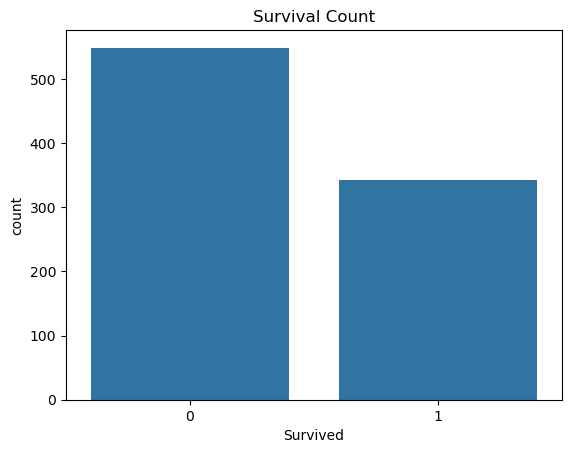

In [4]:
sns.countplot(x='Survived', data=df)
plt.title("Survival Count")
plt.show()

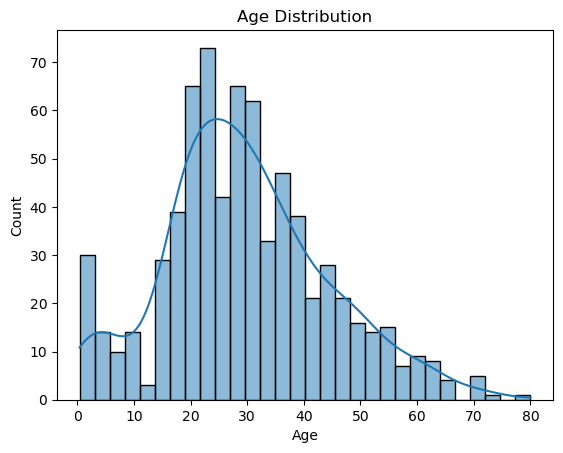

In [5]:
sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.show()


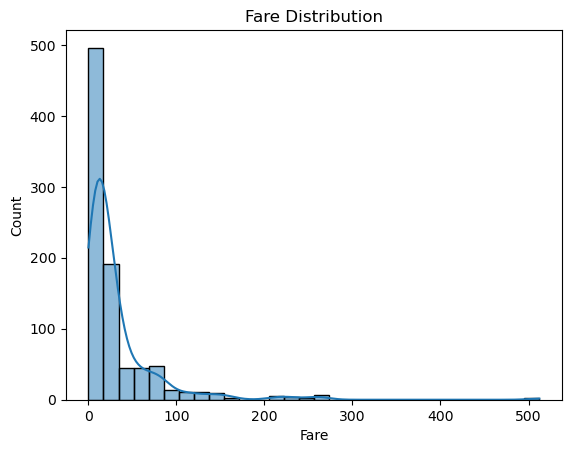

In [7]:
sns.histplot(df['Fare'], bins=30, kde=True)
plt.title("Fare Distribution")
plt.show()

In [6]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Deck'] = df['Cabin'].astype(str).str[0]
df['Deck'] = df['Deck'].replace('n', 'U').fillna('U')

In [8]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower_bound, upper_bound)

In [10]:
df['Age'] = cap_outliers(df['Age'])
df['Fare'] = cap_outliers(df['Fare'])

In [11]:
df['Fare_log'] = np.log1p(df['Fare'])


In [13]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+).', expand=False)
df['Title'] = df['Title'].replace(
    ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare'
)
df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})


In [14]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

df['Pclass_Age'] = df['Pclass'] * df['Age']

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

In [15]:
df = pd.get_dummies(df, columns=['Embarked', 'Deck', 'Title'], drop_first=True)

scaler = StandardScaler()
df['Fare_log_scaled'] = scaler.fit_transform(df[['Fare_log']])

In [16]:
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare', 'Fare_log'], inplace=True)

print("Processed data sample:")
print(df.head())
print("Processed data info:")
print(df.info())
print("Missing values after processing:\n", df.isnull().sum())

Processed data sample:
   Survived  Pclass  Sex   Age  SibSp  Parch  FamilySize  IsAlone  Pclass_Age  \
0         0       3    0  22.0      1      0           2        0        66.0   
1         1       1    1  38.0      1      0           2        0        38.0   
2         1       3    1  26.0      0      0           1        1        78.0   
3         1       1    1  35.0      1      0           2        0        35.0   
4         0       3    0  35.0      0      0           1        1       105.0   

   Embarked_Q  ...  Title_Planke  Title_Rare  Title_Shawah  Title_Steen  \
0       False  ...         False       False         False        False   
1       False  ...         False       False         False        False   
2       False  ...         False       False         False        False   
3       False  ...         False       False         False        False   
4       False  ...         False       False         False        False   

   Title_Velde  Title_Walle  Title_der 

In [17]:
X = df.drop('Survived', axis=1)
y = df['Survived']


In [18]:
dtree = DecisionTreeClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtree.fit(X_train, y_train)
print("Decision Tree Train Accuracy:", dtree.score(X_train, y_train))
print("Decision Tree Test Accuracy:", dtree.score(X_test, y_test))


Decision Tree Train Accuracy: 0.9831460674157303
Decision Tree Test Accuracy: 0.7597765363128491


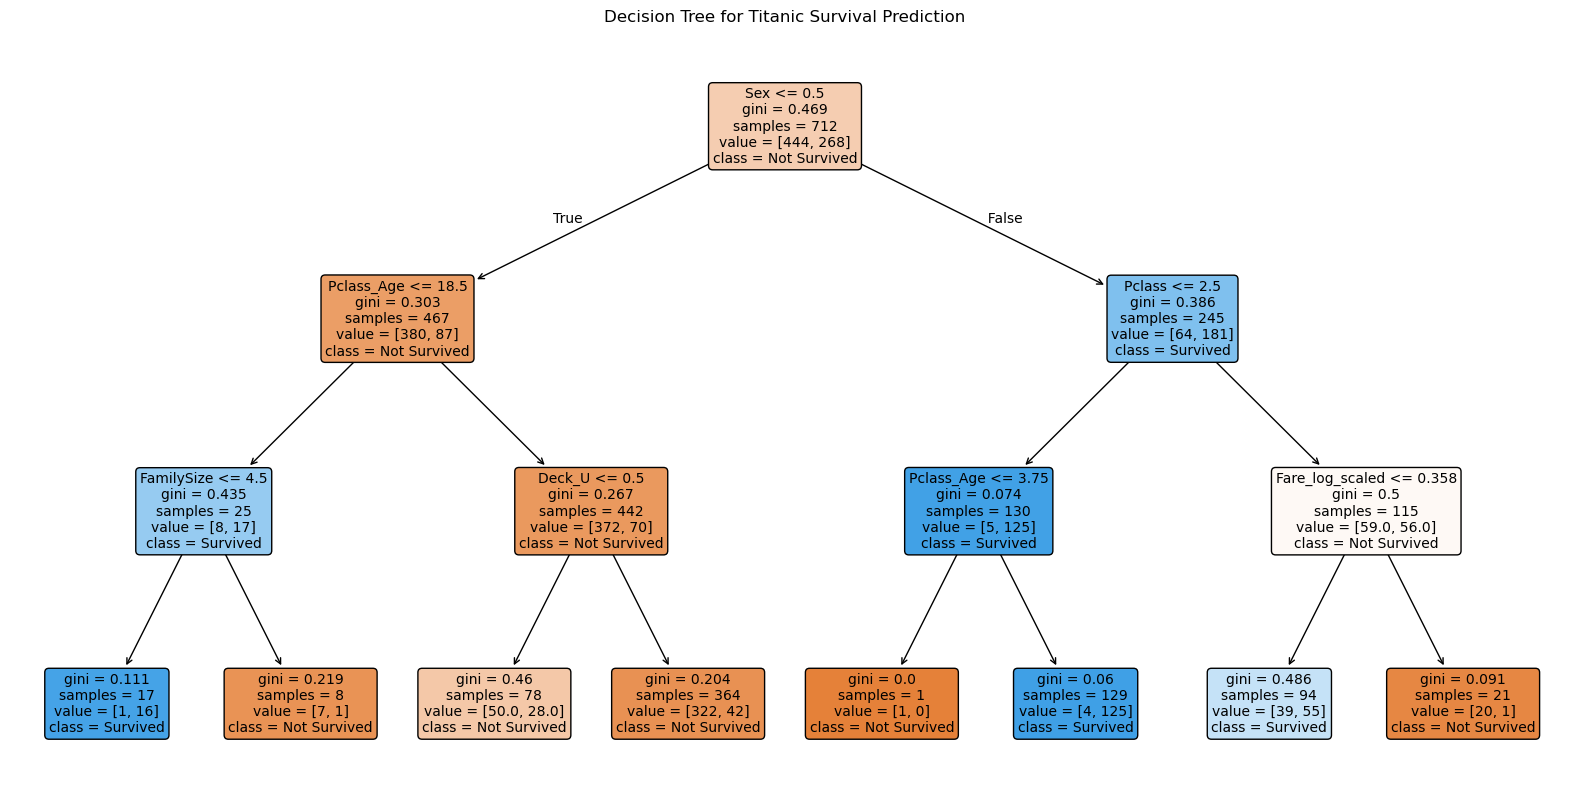

Decision Tree Training Accuracy: 83.71 %
Decision Tree 5-fold CV Scores: [0.83916084 0.83216783 0.81690141 0.78873239 0.82394366]
Decision Tree Average CV Score: 82.02 %


In [21]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'], filled=True,
    rounded=True, fontsize=10)
plt.title("Decision Tree for Titanic Survival Prediction")
plt.show()

Y_pred = clf.predict(X_test)

acc_decision_tree = round(clf.score(X_train, y_train) * 100, 2)
print("Decision Tree Training Accuracy:", acc_decision_tree, "%")

cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Decision Tree 5-fold CV Scores:", cv_scores)
print("Decision Tree Average CV Score:", round(cv_scores.mean() * 100, 2), "%")

In [27]:
# Random forest Mine
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

Y_pred_rf = random_forest.predict(X_test)

acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print("Random Forest Training Accuracy:", acc_random_forest, "%")

rf_cv_scores = cross_val_score(random_forest, X_train, y_train, cv=5)
print("Random Forest 5-fold CV Scores:", rf_cv_scores)
print("Random Forest Average CV Score:", round(rf_cv_scores.mean() * 100, 2), "%")

Random Forest Training Accuracy: 98.31 %
Random Forest 5-fold CV Scores: [0.82517483 0.81818182 0.79577465 0.78169014 0.81690141]
Random Forest Average CV Score: 80.75 %
